abrimos el json


In [2]:
# Con estas 2 lineas recargamos automaticamente todos los archivos afiliados al proyecto, sin necesidad de usar el boton de Restart
%load_ext autoreload
%autoreload 2

from modules.open_json import open_json
import folium
 
mypime = list(open_json("../json/mypime.json"))
geojson = open_json("../json/lha.geojson")
canasta_basica = open_json("../json/canasta_basica.json")
revolico = open_json("../json/revolico.json ")
yerro_m = open_json("./modules/scraping/json_yerro_m/yerro_m.json")


provincia_map = folium.Map(location=(23.133865,-82.3585654))

for i in range(len(mypime)):
    if mypime[i]["ubicacion"]["lat"] is not None and mypime[i]["ubicacion"]["long"] is not None:
        
        folium.Marker(
            location=[mypime[i]["ubicacion"]["lat"], mypime[i]["ubicacion"]["long"]],
            tooltip=f"{mypime[i]["nombre"]}",
            icon=folium.Icon(icon="shopping-cart", color="blue")
        ).add_to(provincia_map)

for j in range(len(yerro_m)):
    if yerro_m[j]["ubicacion"]["lat"] is not None and yerro_m[j]["ubicacion"]["long"] is not None:
             
        folium.Marker(
            location=[yerro_m[j]["ubicacion"]["lat"], yerro_m[j]["ubicacion"]["long"]],
            tooltip=f"{yerro_m[j]["nombre"]}",
            popup= f"<h3>Municipio: {yerro_m[j]["municipio"]}✅  Horario: {yerro_m[j]["horario"]} ⏰</h3>",
            icon=folium.Icon(icon="shopping-cart", color="red")
        ).add_to(provincia_map)
        
        
folium.GeoJson(geojson,
               style_function= lambda x: {
                   "fillColor": "#93FF69",
                   "color": "#08CB00"
               }
               ).add_to(provincia_map)
folium
    
provincia_map

Que se comercializa mas ? las bebidas nacionales o las internacionales

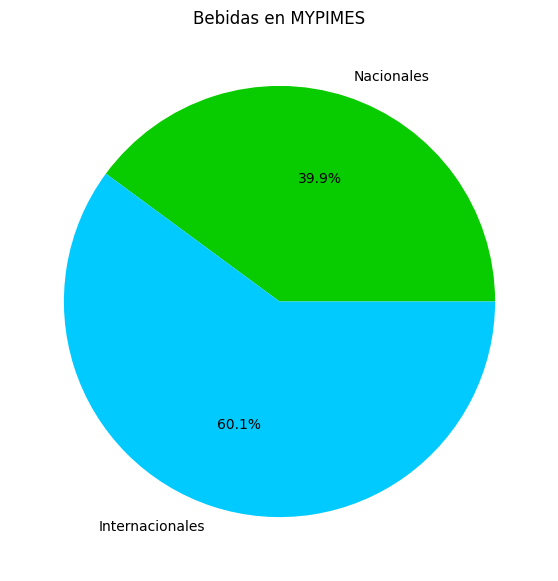

In [3]:
from modules.graphs import bebidas_porciento, yerro_bebida
bebidas_porciento(yerro_bebida(yerro_m))

marcas que mas se comercializan

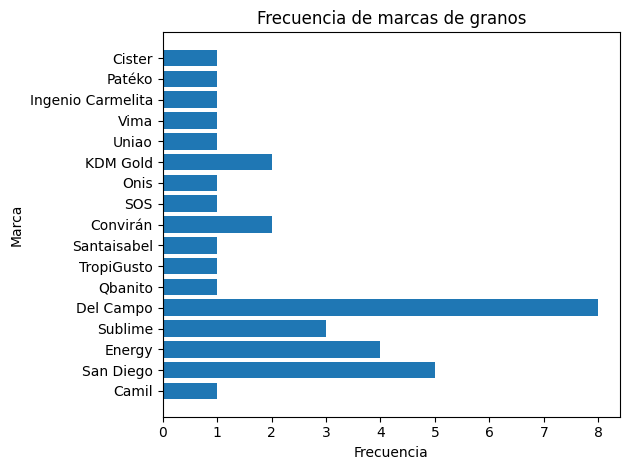

In [4]:
from modules.graphs import productos_mypimes, marcas
import matplotlib.pyplot as plt

a = productos_mypimes(mypime)
marcas(a)


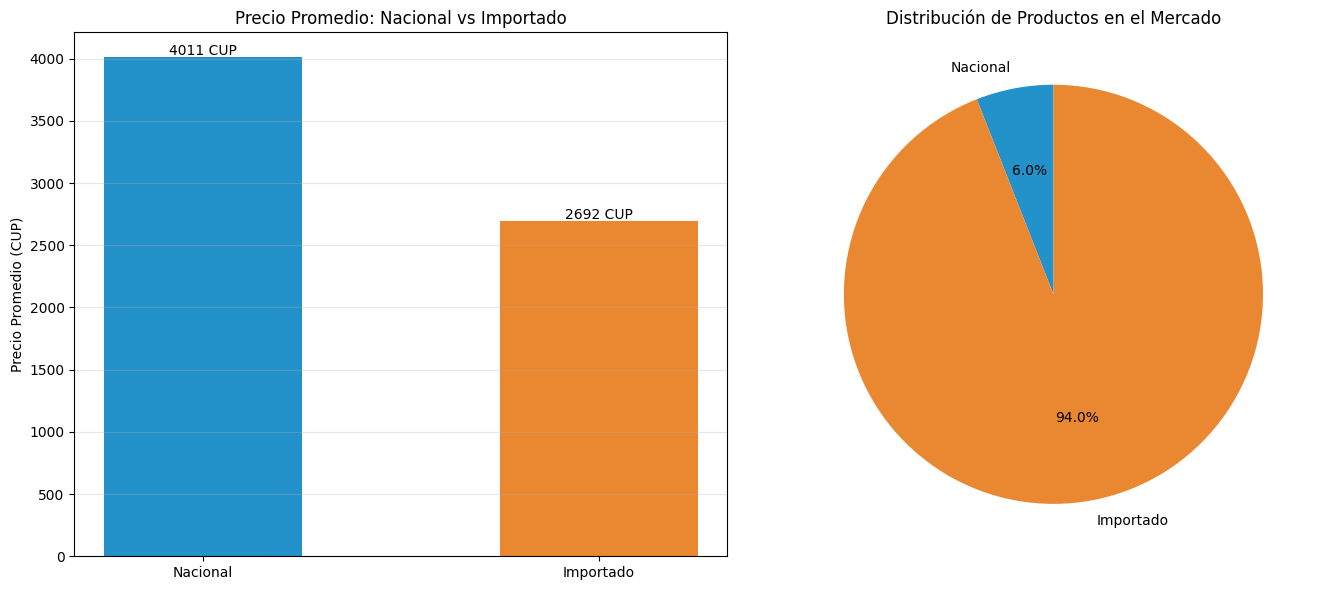

In [5]:
from modules.graphs import promedio, productos_mypimes
def analizar_nacional_vs_importado():
    
    productos = productos_mypimes(mypime)
    
    nacionales = []
    importados = []
    
    for tienda in productos:
            if "nacional" in tienda:
                if tienda["nacional"] == True:
                    nacionales.append(tienda["precio_cup"])
                else:
                    importados.append(tienda["precio_cup"])
    
    promedio_nacional = promedio(nacionales)
    promedio_importado = promedio(importados)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # barras
    categorias = ["Nacional", "Importado"]
    promedios = [promedio_nacional, promedio_importado]
    colores_barras = ["#2492CA", "#ea8832"]
    
    ax1.bar(categorias, promedios, color=colores_barras, width=0.5)
    ax1.set_ylabel("Precio Promedio (CUP)")
    ax1.set_title("Precio Promedio: Nacional vs Importado")
    ax1.grid(axis="y", alpha=0.3)
    
    for i, v in enumerate(promedios):
        ax1.text(i, v + 20, f"{v:.0f} CUP", ha="center")
    
    # pastel
    cantidades = [len(nacionales), len(importados)]
    ax2.pie(cantidades, labels=categorias, autopct="%1.1f%%", colors=colores_barras, startangle=90)
    ax2.set_title("Distribución de Productos en el Mercado")
    
    plt.tight_layout()
    plt.show()

analizar_nacional_vs_importado()

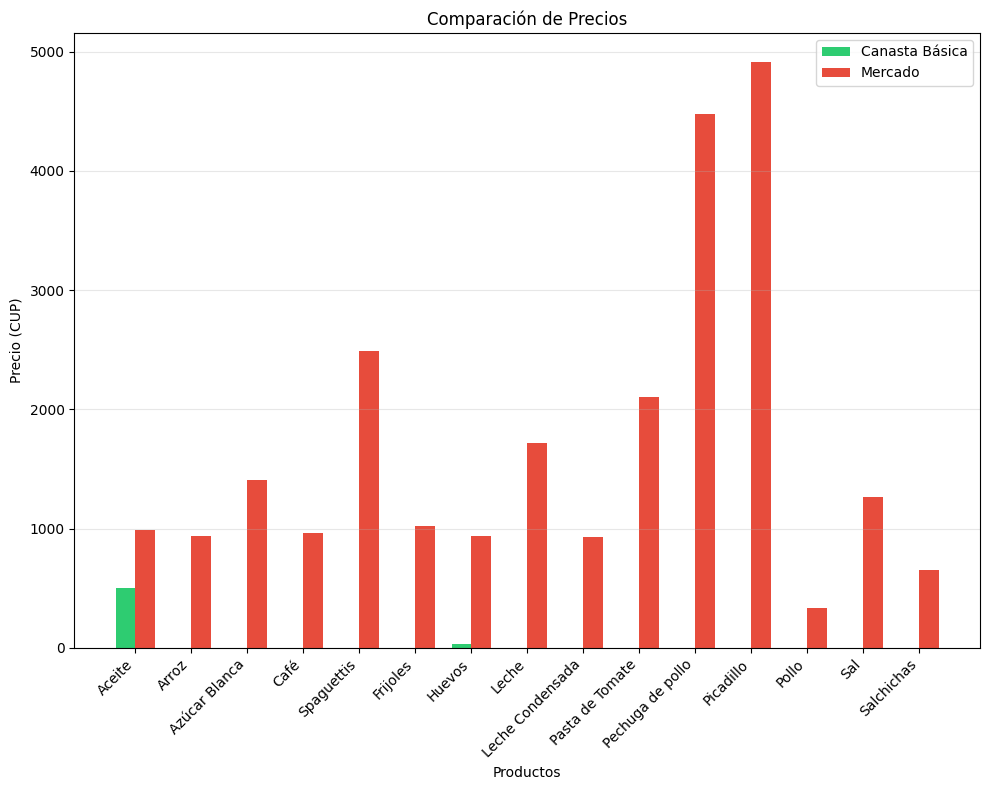

In [6]:
from modules.graphs import promedio, union, productos_mypimes, productos_yerro, cbasica
from modules.scraping.eltoque import eltoque_scraper
import numpy as np

# tasas_cambio = eltoque_scraper()
cb_nombre_productos, cb_productos = cbasica(canasta_basica)

salario_minimo = 2100  
salario_medio = 4500   

horas_dia = 8
dias_mes = 22
horas_mes = horas_dia * dias_mes  

total_canasta_basica = 0
for i in cb_productos:
    total_canasta_basica += i

productos_m_y = []
for j in union(productos_mypimes(mypime), productos_yerro(yerro_m)):
    productos_m_y.append(
        {
            "nombre": j.get("nombre"),
            "precio": j.get("precio_cup")
        }
    )
  
cb_in_union = []
for cb in cb_nombre_productos:
    for my in productos_m_y:
        if cb is not None and my["nombre"] is not None:
            if cb in my["nombre"]:
                cb_in_union.append(my)
                
#---------------------------------

arroz = []
frijoles = []
aceite = []
azucar = []
sal = []
leche = []
leche_condensada = []
salchicha = []
huevos = []
picadillo = []
pollo = []
cafe = []
pechuga_pollo = []
spagutti = []
pasta_tomate = []

for k in cb_in_union:
    if "arroz" in k["nombre"].lower():
        arroz.append(k.get("precio"))
        
    if "frijoles" in k["nombre"].lower():
        frijoles.append(k.get("precio"))

    if "aceite" in k["nombre"].lower():
        aceite.append(k.get("precio"))
        
    if "azucar" in k["nombre"].lower():
        azucar.append(k.get("precio"))
        
    if "sal" in k["nombre"].lower():
        sal.append(k.get("precio"))
        
    if "leche" in k["nombre"].lower():
        leche.append(k.get("precio"))
        
    if "leche condensada" in k["nombre"].lower():
        leche_condensada.append(k.get("precio"))
        
    if "salchicha" in k["nombre"].lower():
        salchicha.append(k.get("precio"))
        
    if "huevo" in k["nombre"].lower():
        huevos.append(k.get("precio"))
        
    if "picadillo" in k["nombre"].lower():
        picadillo.append(k.get("precio"))
        
    if "pollo" in k["nombre"].lower():
        pollo.append(k.get("precio"))
        
    if "cafe" in k["nombre"].lower() or "café" in k["nombre"].lower() :
        cafe.append(k.get("precio"))

    if "pechuga de pollo" in k["nombre"].lower():
        pechuga_pollo.append(k.get("precio"))
        
    if "spaguetti" in k["nombre"].lower():
        spagutti.append(k.get("precio"))
    
    if "pasta de tomate" in k["nombre"].lower():
        pasta_tomate.append(k.get("precio"))

p_aceite = promedio(aceite)
p_arroz = promedio(arroz)
p_azucar = promedio(azucar)
p_cafe = promedio(cafe)
p_spagutti = promedio(spagutti)
p_frijoles = promedio(frijoles)
p_huevos = promedio(huevos)
p_leche = promedio(leche)
p_leche_condensada = promedio(leche_condensada)
p_pasta_tomate = promedio(pasta_tomate)
p_pechuga_pollo = promedio(pechuga_pollo)
p_picadillo = promedio(picadillo)
p_pollo = promedio(pollo)
p_sal = promedio(sal)
p_salchicha = promedio(salchicha)

lista_nombre = ["arroz", "frijoles", "leche", "leche_condensada", "aceite", "sal", "salchicha", "huevos", "picadillo", "pollo", "pechuga_pollo", "cafe", "spagutti", "pasta_tomate", "azucar"]
lista_precio = [p_arroz, p_frijoles, p_leche, p_leche_condensada, p_aceite, p_sal, p_salchicha, p_huevos, p_picadillo, p_pollo, p_pechuga_pollo, p_cafe, p_spagutti, p_pasta_tomate, p_azucar]

nombre_productos = cb_nombre_productos     
precios_cb = cb_productos                 

# comparación de precios canasta básica vs mercado

fig, ax = plt.subplots(figsize=(10, 8))

x = np.arange(len(nombre_productos))  
width = 0.35                          

ax.bar(x - width/2, precios_cb, width, label="Canasta Básica", color="#2ecc71")
ax.bar(x + width/2, lista_precio, width, label="Mercado", color="#e74c3c")
ax.set_xlabel("Productos")
ax.set_ylabel("Precio (CUP)")
ax.set_title("Comparación de Precios")
ax.set_xticks(x)
ax.set_xticklabels(nombre_productos, rotation=45, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


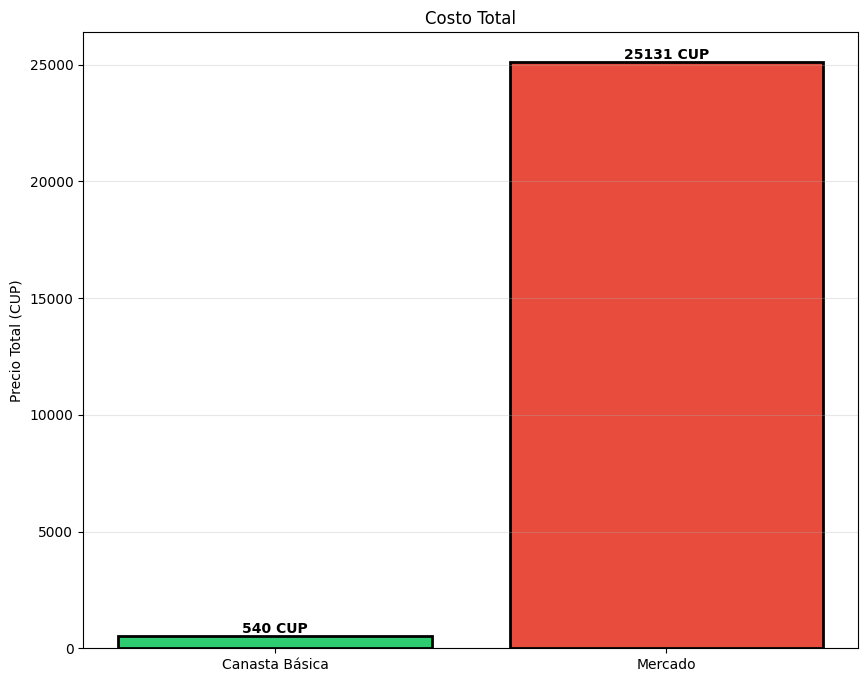

In [7]:
# total canasta básica vs mercado
total_mercado = 0
for i in lista_precio:
    total_mercado += i
    
fig, ax = plt.subplots(figsize=(10, 8))
totales = [total_canasta_basica, total_mercado]
colores = ["#2ecc71", "#e74c3c"]
bars = ax.bar(["Canasta Básica", "Mercado"], totales, color=colores, edgecolor="black", linewidth=2)
ax.set_ylabel("Precio Total (CUP)")
ax.set_title("Costo Total")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.0f} CUP", ha="center", va="bottom", fontweight="bold")



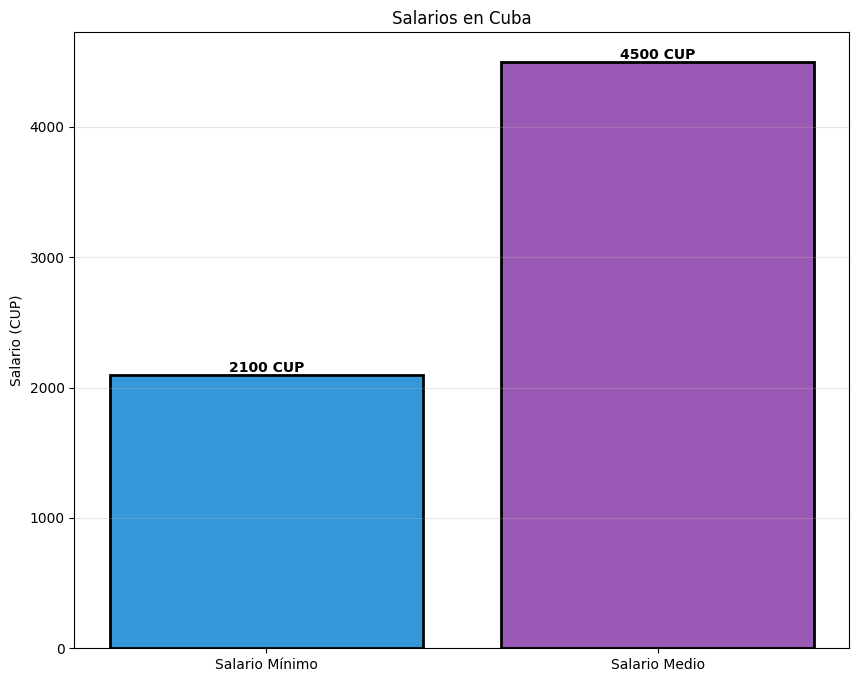

In [8]:
# salarios
fig, ax = plt.subplots(figsize=(10, 8))
salarios = [salario_minimo, salario_medio]
bars = ax.bar(["Salario Mínimo", "Salario Medio"], salarios, color=["#3498db", "#9b59b6"], edgecolor="black", linewidth=2)
ax.set_ylabel("Salario (CUP)")
ax.set_title("Salarios en Cuba")
ax.grid(axis="y", alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f"{height:.0f} CUP", ha="center", va="bottom", fontweight="bold")




Cada barra es la cantidad TOTAL de horas que una persona con salario mínimo o medio debe trabajar en el mes para poder pagar la canasta básica completa.

No es “cuánto por día”, sino “cuántas horas/días de trabajo necesitas en total para cubrir esa canasta con ese salario”.


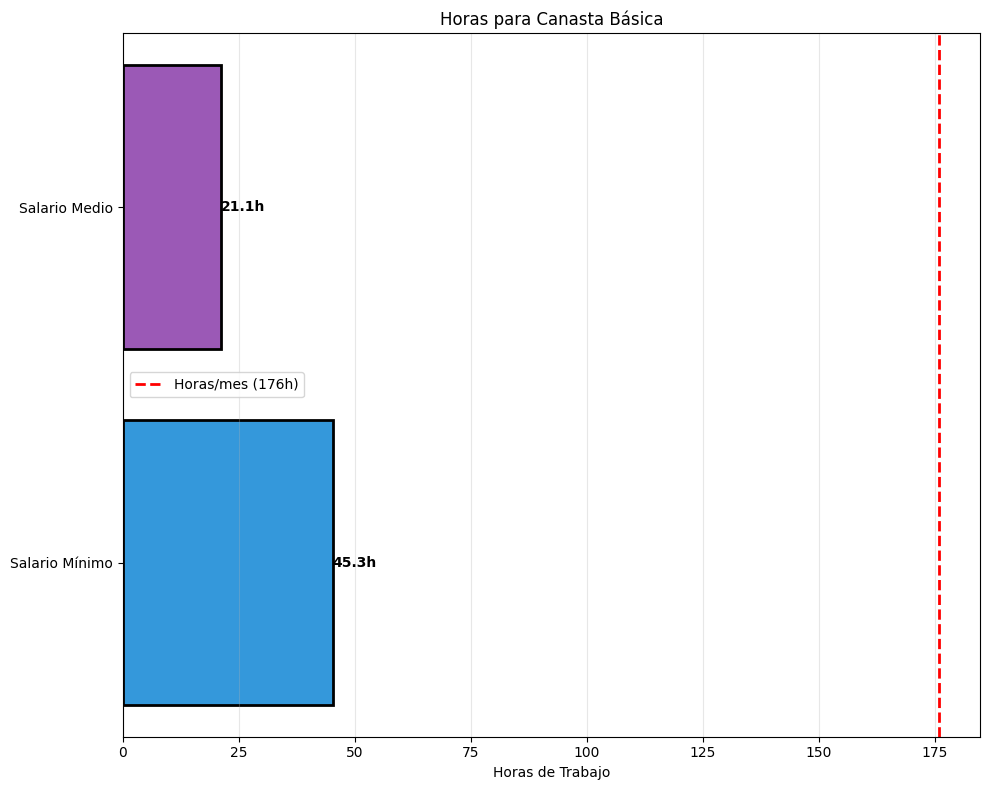

In [9]:
# Horas de trabajo necesarias para cubrir la cansta basica
fig, ax = plt.subplots(figsize=(10, 8))

precio_hora_minimo = salario_minimo / horas_mes
precio_hora_medio = salario_medio / horas_mes

horas_canasta_minimo = total_canasta_basica / precio_hora_minimo
horas_canasta_medio = total_canasta_basica / precio_hora_medio

horas_mercado_minimo = total_mercado / precio_hora_minimo
horas_mercado_medio = total_mercado / precio_hora_medio

dias_canasta_minimo = horas_canasta_minimo / horas_dia
dias_canasta_medio = horas_canasta_medio / horas_dia
dias_mercado_minimo = horas_mercado_minimo / horas_dia
dias_mercado_medio = horas_mercado_medio / horas_dia


horas_cb = [horas_canasta_minimo, horas_canasta_medio]
labels = ["Salario Mínimo", "Salario Medio"]

bars = ax.barh(labels, horas_cb,
               color=["#3498db", "#9b59b6"],
               edgecolor="black",
               linewidth=2)

ax.axvline(x=horas_mes,
           color="red",
           linestyle="--",
           linewidth=2,
           label=f"Horas/mes ({horas_mes}h)")

ax.set_xlabel("Horas de Trabajo")
ax.set_title("Horas para Canasta Básica")
ax.legend()
ax.grid(axis="x", alpha=0.3)

for bar in bars:
    width = bar.get_width()
    ax.text(width,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.1f}h",
            ha="left",
            va="center",
            fontweight="bold")

plt.tight_layout()
plt.show()


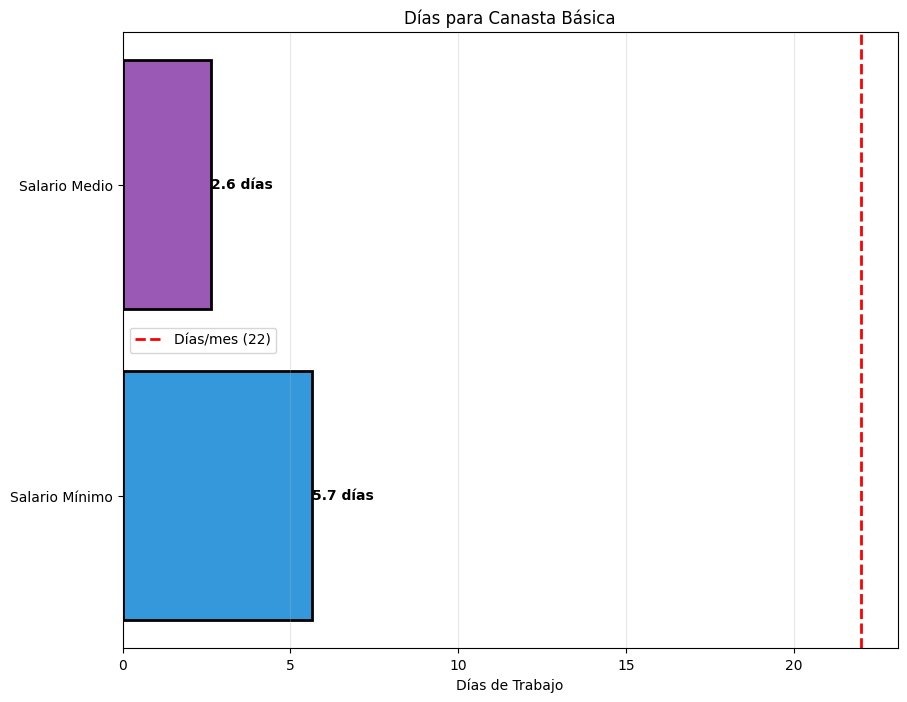

In [10]:
# días de trabajo necesarios (Canasta Básica)
fig, ax = plt.subplots(figsize=(10, 8))
dias_cb = [dias_canasta_minimo, dias_canasta_medio]
bars = ax.barh(["Salario Mínimo", "Salario Medio"], dias_cb, color=["#3498db", "#9b59b6"], edgecolor="black", linewidth=2)
ax.axvline(x=dias_mes, color="red", linestyle="--", linewidth=2, label=f"Días/mes ({dias_mes})")
ax.set_xlabel("Días de Trabajo")
ax.set_title("Días para Canasta Básica")
ax.legend()
ax.grid(axis="x", alpha=0.3)
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
             f"{width:.1f} días", ha="left", va="center", fontweight="bold")


In [11]:
# días con jabón incluido (Salario Mínimo)
ax = plt.subplot(figsize=(10, 8))
comparacion_jabon = [dias_canasta_minimo, dias_con_jabon_minimo]
bars = ax.bar(['Sin Jabón', 'Con Jabón'], comparacion_jabon, color=['#2ecc71', '#f39c12'], edgecolor='black', linewidth=2)
ax.axhline(y=dias_mes, color='red', linestyle='--', linewidth=2, label=f'Días/mes ({dias_mes})')
ax.set_ylabel('Días de Trabajo')
ax.set_title('4. Impacto del Jabón (Salario Mínimo)')
ax.legend()
ax.grid(axis='y', alpha=0.3)
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom', fontweight='bold')


AttributeError: Axes.set() got an unexpected keyword argument 'figsize'

<Figure size 640x480 with 0 Axes>

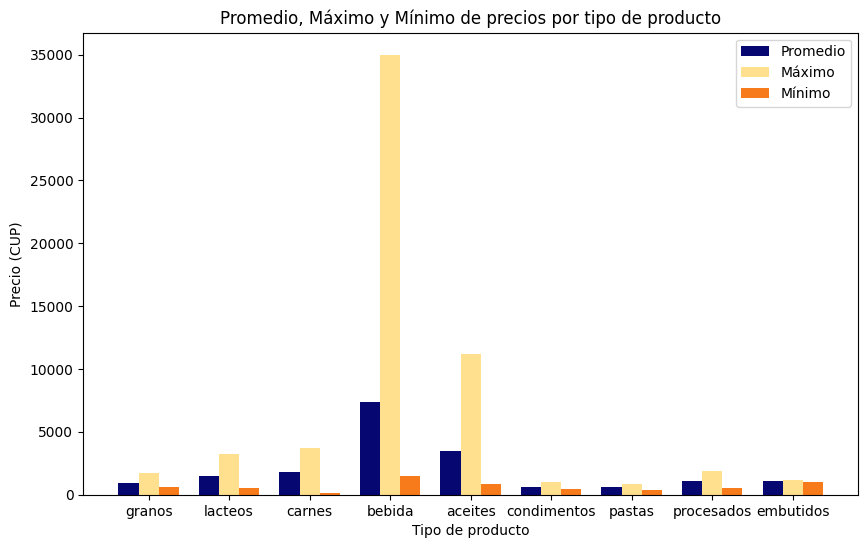

In [ ]:
from modules.graphs import pmm, productos_mypimes
def precios():
    
    tipos_precios = {}
    
    for tienda in productos_mypimes(mypime):
        tipo = tienda["tipo"]
        precio = tienda["precio_cup"]


        if tipo not in tipos_precios:
            tipos_precios[tipo] = []
        tipos_precios[tipo].append(precio)
        
    
    tipos = list(tipos_precios.keys())
    promedios = []
    maximos = []
    minimos = []
    
    for tipo in tipos:
        precios = tipos_precios[tipo]
        promedios.append(sum(precios) / len(precios))
        maximos.append(max(precios))
        minimos.append(min(precios))
    
    pmm(tipos, promedios, maximos, minimos)

precios()

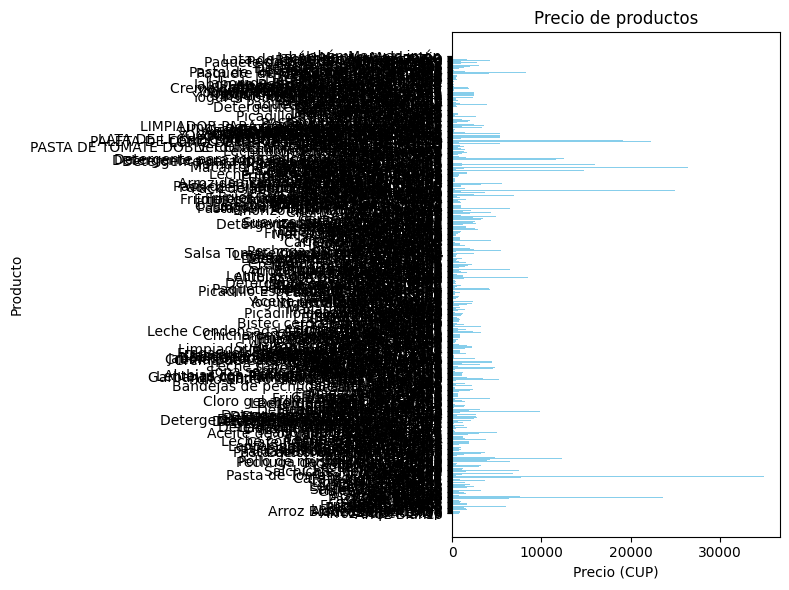

In [34]:
import matplotlib.pyplot as plt
from modules.graphs import union, productos_yerro, productos_mypimes, cbasica

todo = union(productos_mypimes(mypime), productos_yerro(yerro_m))

def presentacion(todo):
    nombres = []
    precios = []

    for tienda in todo:
        nombre = tienda.get("nombre")
        presentacion_val = tienda.get("presentacion")
        precio = tienda.get("precio_cup")

        # si quieres filtrar solo ciertas presentaciones, descomenta:
        # if presentacion_val not in ("g", "kg", "lb"):
        #     continue

        if precio is not None and nombre is not None:
            nombres.append(nombre)
            precios.append(precio)

    # gráfico de barras horizontal
    plt.figure(figsize=(8, 6))
    plt.barh(nombres, precios, color="skyblue")
    plt.xlabel("Precio (CUP)")
    plt.ylabel("Producto")
    plt.title("Precio de productos")
    plt.tight_layout()
    plt.show()

presentacion(todo)
